# Classification: KNeighbors and Logistic regression

In [1]:
import sys
sys.path.append('..')

In [2]:
from source.code.data_loader import DataLoader
from source.code.data_loader import ItemSelector
from source.code.data_loader import MyImputer

from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import QuantileTransformer

from sklearn.linear_model import LogisticRegression

from sklearn.neighbors import KNeighborsClassifier

from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import StratifiedKFold

from sklearn.metrics import make_scorer
from sklearn.metrics import confusion_matrix
from sklearn.metrics import accuracy_score
from sklearn.metrics import precision_score
from sklearn.metrics import recall_score
from sklearn.metrics import f1_score

from imblearn.under_sampling import RandomUnderSampler
from imblearn.under_sampling import ClusterCentroids
from imblearn.over_sampling import RandomOverSampler
from imblearn.over_sampling import ADASYN

import pandas as pd

import numpy as np

import matplotlib.pyplot as plt

import seaborn as sns; sns.set(style="ticks", color_codes=True)

from imblearn.pipeline import Pipeline
from sklearn.pipeline import FeatureUnion

## Auxiliary methods

In [3]:
def perform_classification(X_train, y_train, X_test, y_test, knn_c, lr_c):
    knn_c.fit(X_train, y_train)
    lr_c.fit(X_train, y_train)
    
    k_n_y_pred = knn_c.predict(X_test)
    l_r_y_pred = lr_c.predict(X_test)
    
    show_quality_results(y_test, k_n_y_pred, l_r_y_pred)

In [4]:
def show_quality_results(y_test, k_n_y_pred, l_r_y_pred):
    k_n_precision_sc = precision_score(y_test, k_n_y_pred)
    k_n_accuracy_sc = accuracy_score(y_test, k_n_y_pred)
    k_n_recall_sc = recall_score(y_test, k_n_y_pred)
    k_n_f1_sc = f1_score(y_test, k_n_y_pred)
    k_n_conf_matrix = confusion_matrix(y_test, k_n_y_pred)

    l_r_precision_sc = precision_score(y_test, l_r_y_pred)
    l_r_accuracy_sc = accuracy_score(y_test, l_r_y_pred)
    l_r_recall_sc = recall_score(y_test, l_r_y_pred)
    l_r_f1_sc = f1_score(y_test, l_r_y_pred)
    l_r_conf_matrix = confusion_matrix(y_test, l_r_y_pred)
    
    f, axs = plt.subplots(1, 2, figsize=(15, 5))
    sns.heatmap(k_n_conf_matrix, annot=True, fmt="d", ax=axs[0])
    sns.heatmap(l_r_conf_matrix, annot=True, fmt="d", ax=axs[1])
    axs[0].set_title("K-nearest neighbours\nPrecision: {0:f},\nRecall: {1:f},\nF-score: {2:f},\nAccuracy: {3:f}".format(k_n_precision_sc, k_n_recall_sc, k_n_f1_sc, k_n_accuracy_sc))
    axs[1].set_title("Logistic regression\nPrecision: {0:f},\nRecall: {1:f},\nF-score: {2:f},\nAccuracy: {3:f}".format(l_r_precision_sc, l_r_recall_sc, l_r_f1_sc, l_r_accuracy_sc))
    axs[0].set_xlabel("Predicted classes")
    axs[1].set_xlabel("Predicted classes")
    axs[0].set_ylabel("True classes")
    axs[1].set_ylabel("True classes")
    plt.show()

In [5]:
def plot_results(ax, metric_mean_1, metric_mean_2, metric_mean_3, metric_std_1, metric_std_2, metric_std_3, title, x_label, y_label, xticklabels, legend):
    N = len(xticklabels)
    ind = np.arange(N)
    width = 0.15
    ax.bar(ind, metric_mean_1, width, color='r', yerr=metric_std_1)
    ax.bar(ind + width, metric_mean_2, width, color='g', yerr=metric_std_2)
    ax.bar(ind + 2 * width, metric_mean_3, width, color='b', yerr=metric_std_3)
    ax.set_ylabel(y_label)
    ax.set_xlabel(x_label)
    ax.set_title(title)
    ax.set_xticks(ind + width / N)
    ax.set_xticklabels(xticklabels)
    ax.legend(legend, loc=0)

In [6]:
def display_results(test_statistics, metric):
    fig, axes = plt.subplots(4, 2, figsize=(24, 22))
    params = (
        'Neighbors count',
        metric,
        ('3', '4', '5', '6', '7', '8'),
        ('Метрика Манхэттена (p: 1)', 'Евклидова метрика (p: 2)', 'Метрика Минковского III-го порядка (p: 3)')
    )
    for i in range(8):
        plot_results(
            axes[i // 2, i % 2],
            test_statistics[0][0, i // 2, 0:, 0:, i % 2][0:, 0],
            test_statistics[0][0, i // 2, 0:, 0:, i % 2][0:, 1],
            test_statistics[0][0, i // 2, 0:, 0:, i % 2][0:, 2],
            test_statistics[1][0, i // 2, 0:, 0:, i % 2][0:, 0],
            test_statistics[1][0, i // 2, 0:, 0:, i % 2][0:, 1],
            test_statistics[1][0, i // 2, 0:, 0:, i % 2][0:, 2],
            '{} by metric order and neighbors count for leaf size: {} and weighting strategy: {}'.format(metric, 10 + 5 * (i // 2), 'uniform' if i % 2 == 0 else 'distance'),
            *params
        )
    plt.tight_layout()
    plt.show()

In [7]:
def find_the_best_classifier(X, y, base_classifier, grid_search_params, metric_to_maximize):
    # Здесь, пожалуй, стоит подчеркнуть важность выбора в сторону стратифицированной валидации, поскольку речь идет о задаче классификации.
    # Данный тип валидации сохраняет пропорцию классов в фолдах, так что мы можем предполагать, что разброс значений метрик на тесте не будет высоким.
    grid_search = GridSearchCV(
        estimator=base_classifier,
        param_grid=grid_search_params,
        cv=StratifiedKFold(n_splits=6),
        scoring={'accuracy': make_scorer(accuracy_score),
                 'precision': make_scorer(precision_score),
                 'recall': make_scorer(recall_score),
                 'f1': make_scorer(f1_score)},
        refit=metric_to_maximize,
        n_jobs=8
    )
    grid_search.fit(X, y)
    return grid_search

## Initial data loading

In [8]:
with open('../data/description/datasets', 'r') as source:
    datasets = source.readlines()
datasets = [dataset.replace('\n', '') for dataset in datasets]
dataset_path_pattern = '../data/{}/{}.{}.txt'
data_paths = [dataset_path_pattern.format('train', dataset, 'data') for dataset in datasets] + [dataset_path_pattern.format('test', dataset, 'test') for dataset in datasets]
data_loader = DataLoader(data_paths, '../data/description/columns', '../data/description/classes')
data_frame = data_loader.load()

## Dataset description

Собственно датасет представляет собой описание симптомов пациентов.

Цель - определение заболевания щитовидной железы (диагноз - целевая переменная).

Данные резбиты на несколько файлов, шесть пар файлов (для обучения и контроля) имеют одинаковою структуру, остальные отличаются по количеству признаков и порядку следования.

В данной работе используются только эти шесть пар файлов.

Также стоит отметить, что целевая переменная в разных файлах имеет разное количество разных диагнозов, однако все в целом могут быть разделены на две группы: здоров, болен.

Здесь задача многоклассовой классификации сводится к бинарной.

## EDA

In [9]:
data_frame.head()

,age,sex,on thyroxine,query on thyroxine,on antithyroid medication,sick,pregnant,thyroid surgery,I131 treatment,query hypothyroid,...,TT4 measured,TT4,T4U measured,T4U,FTI measured,FTI,TBG measured,TBG,referral source,diagnosis
0,41.0,1.0,False,False,False,False,False,False,False,False,...,True,125.0,True,1.14,True,109.0,False,None,SVHC,False
1,23.0,1.0,False,False,False,False,False,False,False,False,...,True,102.0,False,NaN,False,NaN,False,None,other,False
2,46.0,0.0,False,False,False,False,False,False,False,False,...,True,109.0,True,0.91,True,120.0,False,None,other,False
3,70.0,1.0,True,False,False,False,False,False,False,False,...,True,175.0,False,NaN,False,NaN,False,None,other,False
4,70.0,1.0,False,False,False,False,False,False,False,False,...,True,61.0,True,0.87,True,70.0,False,None,SVI,False


In [10]:
data_frame.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 22632 entries, 0 to 971
Data columns (total 30 columns):
age                          22626 non-null float64
sex                          21732 non-null float64
on thyroxine                 22632 non-null bool
query on thyroxine           22632 non-null bool
on antithyroid medication    22632 non-null bool
sick                         22632 non-null bool
pregnant                     22632 non-null bool
thyroid surgery              22632 non-null bool
I131 treatment               22632 non-null bool
query hypothyroid            22632 non-null bool
query hyperthyroid           22632 non-null bool
lithium                      22632 non-null bool
goitre                       22632 non-null bool
tumor                        22632 non-null bool
hypopituitary                22632 non-null bool
psych                        22632 non-null bool
TSH measured                 22632 non-null bool
TSH                          20418 non-null float64
T3

In [11]:
data_frame.describe()

,age,sex,TSH,T3,TT4,T4U,FTI
count,22626.000000,21732.000000,20418.000000,18018.000000,21246.000000,20310.000000,20322.000000
mean,51.735879,0.684705,5.086766,2.013500,108.319345,0.995000,110.469649
std,20.082739,0.464644,24.518468,0.827319,35.600058,0.195433,33.085627
min,1.000000,0.000000,0.005000,0.050000,2.000000,0.250000,2.000000
25%,36.000000,0.000000,0.500000,1.600000,88.000000,0.880000,93.000000
50%,54.000000,1.000000,1.400000,2.000000,103.000000,0.980000,107.000000
75%,67.000000,1.000000,2.700000,2.400000,124.000000,1.080000,124.000000
max,455.000000,1.000000,530.000000,10.600000,430.000000,2.320000,395.000000


После объединения могло возникнуть некоторое количество дупликатов, попробуем от них избавиться:

In [12]:
data_frame.drop_duplicates(inplace=True)

In [13]:
data_frame.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 4619 entries, 0 to 909
Data columns (total 30 columns):
age                          4618 non-null float64
sex                          4435 non-null float64
on thyroxine                 4619 non-null bool
query on thyroxine           4619 non-null bool
on antithyroid medication    4619 non-null bool
sick                         4619 non-null bool
pregnant                     4619 non-null bool
thyroid surgery              4619 non-null bool
I131 treatment               4619 non-null bool
query hypothyroid            4619 non-null bool
query hyperthyroid           4619 non-null bool
lithium                      4619 non-null bool
goitre                       4619 non-null bool
tumor                        4619 non-null bool
hypopituitary                4619 non-null bool
psych                        4619 non-null bool
TSH measured                 4619 non-null bool
TSH                          4286 non-null float64
T3 measured          

In [14]:
data_frame.describe()

,age,sex,TSH,T3,TT4,T4U,FTI
count,4618.000000,4435.000000,4286.000000,3778.000000,4442.000000,4247.000000,4249.000000
mean,52.066046,0.694701,7.068102,2.007740,109.621027,1.002579,111.270981
std,20.077794,0.460586,30.597431,0.963957,40.885925,0.215204,38.158859
min,1.000000,0.000000,0.005000,0.050000,2.000000,0.250000,2.000000
25%,36.000000,0.000000,0.410000,1.500000,86.000000,0.870000,92.000000
50%,55.000000,1.000000,1.400000,2.000000,104.000000,0.980000,107.000000
75%,68.000000,1.000000,3.200000,2.400000,129.000000,1.090000,126.000000
max,455.000000,1.000000,530.000000,10.600000,430.000000,2.320000,395.000000


Судя по всему подавляющее большинство информации в датастах было дуплицировано.
Это также может быть объяснено тем, что все случаи положительных диагнозов были схлопнуты в один, поэтому пациенты с одинаковыми симптомами, но разными диагнозами из разных выборок стали идентичными.

Из описания видно, что признак TBG не содержит ни одного ненулевого значения, соответственно значение данного признака не было измерено ни для одного пациента. Данный признак (а соответственно и признак TBG measured) можно удалить из выборки:

In [15]:
data_frame.drop(['TBG measured', 'TBG'], axis='columns', inplace=True)

In [16]:
data_frame.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 4619 entries, 0 to 909
Data columns (total 28 columns):
age                          4618 non-null float64
sex                          4435 non-null float64
on thyroxine                 4619 non-null bool
query on thyroxine           4619 non-null bool
on antithyroid medication    4619 non-null bool
sick                         4619 non-null bool
pregnant                     4619 non-null bool
thyroid surgery              4619 non-null bool
I131 treatment               4619 non-null bool
query hypothyroid            4619 non-null bool
query hyperthyroid           4619 non-null bool
lithium                      4619 non-null bool
goitre                       4619 non-null bool
tumor                        4619 non-null bool
hypopituitary                4619 non-null bool
psych                        4619 non-null bool
TSH measured                 4619 non-null bool
TSH                          4286 non-null float64
T3 measured          

In [17]:
data_frame.describe()

,age,sex,TSH,T3,TT4,T4U,FTI
count,4618.000000,4435.000000,4286.000000,3778.000000,4442.000000,4247.000000,4249.000000
mean,52.066046,0.694701,7.068102,2.007740,109.621027,1.002579,111.270981
std,20.077794,0.460586,30.597431,0.963957,40.885925,0.215204,38.158859
min,1.000000,0.000000,0.005000,0.050000,2.000000,0.250000,2.000000
25%,36.000000,0.000000,0.410000,1.500000,86.000000,0.870000,92.000000
50%,55.000000,1.000000,1.400000,2.000000,104.000000,0.980000,107.000000
75%,68.000000,1.000000,3.200000,2.400000,129.000000,1.090000,126.000000
max,455.000000,1.000000,530.000000,10.600000,430.000000,2.320000,395.000000


Заметим, что TSH measured, T3 measured, TT4 measured, T4U measured и FTI measured просто показывают, было ли измерено у пациента значение признаков TSH, T3, TT4, T4U и FTI соответственно. Данная информация избыточна, поскольку по значению этих признаков можно понять были они измерены или нет (наличие или отсутствие NaN), TSH measured, T3 measured, TT4 measured, T4U measured и FTI measured также можно удалить из выборки:

In [18]:
data_frame.drop(['TSH measured', 'T3 measured', 'TT4 measured', 'T4U measured', 'FTI measured'], axis='columns', inplace=True)

In [19]:
data_frame.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 4619 entries, 0 to 909
Data columns (total 23 columns):
age                          4618 non-null float64
sex                          4435 non-null float64
on thyroxine                 4619 non-null bool
query on thyroxine           4619 non-null bool
on antithyroid medication    4619 non-null bool
sick                         4619 non-null bool
pregnant                     4619 non-null bool
thyroid surgery              4619 non-null bool
I131 treatment               4619 non-null bool
query hypothyroid            4619 non-null bool
query hyperthyroid           4619 non-null bool
lithium                      4619 non-null bool
goitre                       4619 non-null bool
tumor                        4619 non-null bool
hypopituitary                4619 non-null bool
psych                        4619 non-null bool
TSH                          4286 non-null float64
T3                           3778 non-null float64
TT4               

Заметим, что в данных присутствуют записи о неопределившихся с полом:

In [20]:
data_frame[(data_frame.sex.isnull())].sort_index().info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 184 entries, 16 to 2786
Data columns (total 23 columns):
age                          184 non-null float64
sex                          0 non-null float64
on thyroxine                 184 non-null bool
query on thyroxine           184 non-null bool
on antithyroid medication    184 non-null bool
sick                         184 non-null bool
pregnant                     184 non-null bool
thyroid surgery              184 non-null bool
I131 treatment               184 non-null bool
query hypothyroid            184 non-null bool
query hyperthyroid           184 non-null bool
lithium                      184 non-null bool
goitre                       184 non-null bool
tumor                        184 non-null bool
hypopituitary                184 non-null bool
psych                        184 non-null bool
TSH                          165 non-null float64
T3                           156 non-null float64
TT4                          169 non-

Глянем, есть ли среди неопределившихся с полом беременные:

In [21]:
data_frame[(data_frame.sex.isnull()) & (data_frame.pregnant)]

,age,sex,on thyroxine,query on thyroxine,on antithyroid medication,sick,pregnant,thyroid surgery,I131 treatment,query hypothyroid,...,tumor,hypopituitary,psych,TSH,T3,TT4,T4U,FTI,referral source,diagnosis
1609,73.0,NaN,False,False,False,False,True,False,False,False,...,False,False,False,2.2,2.5,110.0,1.28,85.0,other,False
471,21.0,NaN,False,False,False,False,True,False,False,False,...,True,False,False,2.4,3.5,171.0,1.49,115.0,STMW,False
471,21.0,NaN,False,False,False,False,True,False,False,False,...,True,False,False,2.4,3.5,171.0,1.49,115.0,STMW,True


Поскольку пол - довольно важный признак и поскольку неопределившиеся составляют $100 \cdot \frac{185}{4680} \approx 4\%$, будет проще избавиться от данной части выборки:

In [22]:
patients_without_sex = data_frame[(data_frame.sex.isnull())]
data_frame.drop(data_frame[(data_frame.sex.isnull())].index, inplace=True)

In [23]:
data_frame.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 4341 entries, 0 to 909
Data columns (total 23 columns):
age                          4340 non-null float64
sex                          4341 non-null float64
on thyroxine                 4341 non-null bool
query on thyroxine           4341 non-null bool
on antithyroid medication    4341 non-null bool
sick                         4341 non-null bool
pregnant                     4341 non-null bool
thyroid surgery              4341 non-null bool
I131 treatment               4341 non-null bool
query hypothyroid            4341 non-null bool
query hyperthyroid           4341 non-null bool
lithium                      4341 non-null bool
goitre                       4341 non-null bool
tumor                        4341 non-null bool
hypopituitary                4341 non-null bool
psych                        4341 non-null bool
TSH                          4032 non-null float64
T3                           3538 non-null float64
TT4               

Остался еще один пациент, у которого не указан возраст:

In [24]:
data_frame[(data_frame.age.isnull())]

,age,sex,on thyroxine,query on thyroxine,on antithyroid medication,sick,pregnant,thyroid surgery,I131 treatment,query hypothyroid,...,tumor,hypopituitary,psych,TSH,T3,TT4,T4U,FTI,referral source,diagnosis
1985,NaN,1.0,True,False,False,False,False,False,True,False,...,False,False,False,0.6,1.5,120.0,0.82,146.0,other,False


Можно было бы посчитать сколько-нибудь ближайших к данному персонажу личностей потом по медиане взять возраст,
однако для этого нужно либо ранжировать всю выборку либо случайным образом доставать похожих по симптомам пациентов.
Гораздо проще исключить пока этот объект из выборки, поскольку вряд ли отсутствие одного пациента существенно сместит результаты обучения:

In [25]:
data_frame.drop(data_frame[(data_frame.age.isnull())].index, inplace=True)

In [26]:
data_frame.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 4340 entries, 0 to 909
Data columns (total 23 columns):
age                          4340 non-null float64
sex                          4340 non-null float64
on thyroxine                 4340 non-null bool
query on thyroxine           4340 non-null bool
on antithyroid medication    4340 non-null bool
sick                         4340 non-null bool
pregnant                     4340 non-null bool
thyroid surgery              4340 non-null bool
I131 treatment               4340 non-null bool
query hypothyroid            4340 non-null bool
query hyperthyroid           4340 non-null bool
lithium                      4340 non-null bool
goitre                       4340 non-null bool
tumor                        4340 non-null bool
hypopituitary                4340 non-null bool
psych                        4340 non-null bool
TSH                          4031 non-null float64
T3                           3537 non-null float64
TT4               

Извлечем пока из выборки признак referal source:

In [27]:
referral_source = data_frame['referral source']
data_frame.drop(['referral source'], axis='columns', inplace=True)

In [28]:
data_frame.head()

,age,sex,on thyroxine,query on thyroxine,on antithyroid medication,sick,pregnant,thyroid surgery,I131 treatment,query hypothyroid,...,goitre,tumor,hypopituitary,psych,TSH,T3,TT4,T4U,FTI,diagnosis
0,41.0,1.0,False,False,False,False,False,False,False,False,...,False,False,False,False,1.30,2.5,125.0,1.14,109.0,False
1,23.0,1.0,False,False,False,False,False,False,False,False,...,False,False,False,False,4.10,2.0,102.0,NaN,NaN,False
2,46.0,0.0,False,False,False,False,False,False,False,False,...,False,False,False,False,0.98,NaN,109.0,0.91,120.0,False
3,70.0,1.0,True,False,False,False,False,False,False,False,...,False,False,False,False,0.16,1.9,175.0,NaN,NaN,False
4,70.0,1.0,False,False,False,False,False,False,False,False,...,False,False,False,False,0.72,1.2,61.0,0.87,70.0,False


In [29]:
data_frame.index = range(data_frame.index.size)

Отделим целевой признак (диагноз) от предикторов (первых 21 признаков):

In [30]:
y = data_frame['diagnosis']
X = data_frame.drop(['diagnosis'], axis='columns')

## Pipeline building

Далее будет описан pipeline, который должен включать в себя:
- заполнение признаков в соответствии с выбранным методом (выборочное среднее, выборочная медиана, выборочная мода);
- масштабирование вещественных признаков;
- квантильное преобразование вещественных признаков;
- баланировку классов;
- обучение метода К-ближайших соседей/логистической регрессии.

In [31]:
continuous_features = ['age', 'TSH', 'T3', 'TT4', 'T4U', 'FTI']
binary_features = list(set(X.columns).difference(continuous_features))

In [32]:
logistic_regression_pipeline = Pipeline([
    ('impute', MyImputer(strategy='median')),
    ('union', FeatureUnion([
        ('binary', Pipeline([
            ('select', ItemSelector(binary_features))
        ])),
        ('continuous', Pipeline([
            ('select', ItemSelector(continuous_features)),
            ('scale', StandardScaler()),
            ('transform', QuantileTransformer())
        ]))
    ])),
    ('balancer', RandomUnderSampler(random_state=42)),
    ('fit', LogisticRegression(random_state=42))
])

In [33]:
nearest_neighbors_pipeline = Pipeline([
    ('impute', MyImputer(strategy='median')),
    ('union', FeatureUnion([
        ('binary', Pipeline([
            ('select', ItemSelector(binary_features))
        ])),
        ('continuous', Pipeline([
            ('select', ItemSelector(continuous_features)),
            ('scale', StandardScaler()),
            ('transform', QuantileTransformer(random_state=42))
        ]))
    ])),
    ('balancer', RandomUnderSampler(random_state=42)),
    ('fit', KNeighborsClassifier())
])

Итак, у нас есть некий базовый слепок выборки, теперь попробуем обучить логистическую регрессию и метод К-ближайших соседей.

Пока что без особого вмешательства, просто чтобы глянуть, что получится, если запустить дефолтный pipeline.

Разделим предварительно выборку на обучающую и тестовую:

In [34]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33, random_state=42)

In [35]:
logistic_regression_pipeline.fit(X_train, y_train)
nearest_neighbors_pipeline.fit(X_train, y_train)

Pipeline(memory=None,
     steps=[('impute', MyImputer(strategy='median')), ('union', FeatureUnion(n_jobs=1,
       transformer_list=[('binary', Pipeline(memory=None,
     steps=[('select', ItemSelector(columns=['sick', 'query hyperthyroid', 'on antithyroid medication', 'I131 treatment', 'goitre', 'thyroid surgery', 'lithium'...owski',
           metric_params=None, n_jobs=1, n_neighbors=5, p=2,
           weights='uniform'))])

In [36]:
l_r_y_pred = logistic_regression_pipeline.predict(X_test)
k_n_y_pred = nearest_neighbors_pipeline.predict(X_test)

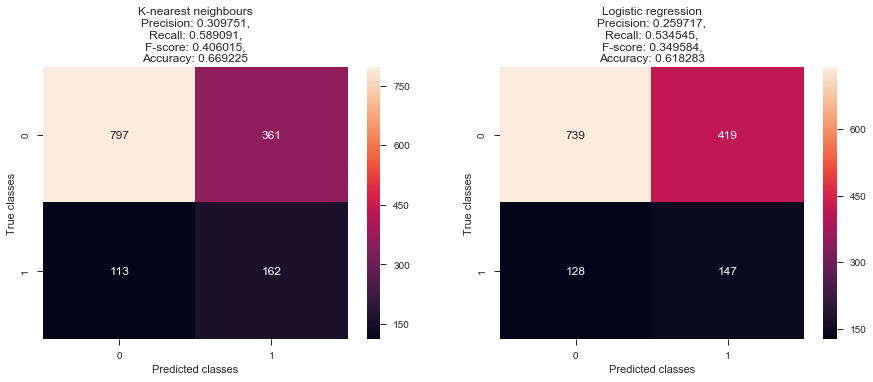

In [37]:
show_quality_results(y_test, k_n_y_pred, l_r_y_pred)

## Hyperparameters tunning

In [38]:
strategies = ['mean', 'median', 'most_frequent']
balancers = [RandomUnderSampler(random_state=42), RandomOverSampler(random_state=42), ClusterCentroids(random_state=42), ADASYN(random_state=42)]

In [39]:
n_neighbors = [3, 4, 5, 6, 7, 8]
leaf_size = [5, 10, 15, 20, 25, 30, 35]
p = [1, 2]
algorithm = ['ball_tree', 'kd_tree']

In [40]:
C = np.arange(0.1, 10.0, 0.5)
class_weight = [{False: 1.0, True: w} for w in np.arange(1, 10.0, 1.0)]
penalty = ['l1', 'l2']
fit_intercept = [True, False]

In [41]:
k_n_grid_search_params = [
    {
        'impute__strategy': strategies,
        'balancer': balancers,
        'fit': [KNeighborsClassifier()],
        'fit__n_neighbors': n_neighbors,
        'fit__leaf_size': leaf_size,
        'fit__p': p,
        'fit__algorithm': algorithm
    }
]
l_r_grid_search_params = [
    {
        'impute__strategy': strategies,
        'balancer': balancers,
        'fit': [LogisticRegression(random_state=42)],
        'fit__C': C,
        'fit__class_weight': class_weight,
        'fit__penalty': penalty,
        'fit__fit_intercept': fit_intercept
    }
]

In [42]:
nearest_neighbors_pipeline = Pipeline([
    ('impute', MyImputer(strategy='median')),
    ('union', FeatureUnion([
        ('binary', Pipeline([
            ('select', ItemSelector(binary_features))
        ])),
        ('continuous', Pipeline([
            ('select', ItemSelector(continuous_features)),
            ('scale', StandardScaler()),
            ('transform', QuantileTransformer(random_state=42))
        ]))
    ])),
    ('balancer', RandomUnderSampler(random_state=42)),
    ('fit', KNeighborsClassifier())
])
k_n_grid_search = find_the_best_classifier(X_train, y_train, nearest_neighbors_pipeline, k_n_grid_search_params, 'f1')

In [ ]:
logistic_regression_pipeline = Pipeline([
    ('impute', MyImputer(strategy='median')),
    ('union', FeatureUnion([
        ('binary', Pipeline([
            ('select', ItemSelector(binary_features))
        ])),
        ('continuous', Pipeline([
            ('select', ItemSelector(continuous_features)),
            ('scale', StandardScaler()),
            ('transform', QuantileTransformer(random_state=42))
        ]))
    ])),
    ('balancer', RandomUnderSampler(random_state=42)),
    ('fit', LogisticRegression(random_state=42))
])
l_r_grid_search = find_the_best_classifier(X_train, y_train, logistic_regression_pipeline, l_r_grid_search_params, 'f1')

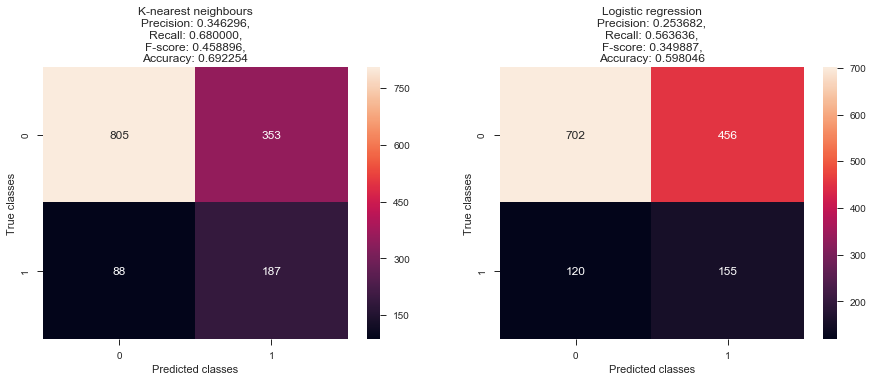

In [44]:
k_n_y_pred = k_n_grid_search.best_estimator_.predict(X_test)
l_r_y_pred = l_r_grid_search.best_estimator_.predict(X_test)
show_quality_results(y_test, k_n_y_pred, l_r_y_pred)

In [123]:
k_n_table_columns = list(k_n_grid_search_params[0].keys())

data = {k_n_table_columns[i]: [k_n_grid_search.cv_results_['params'][j][k_n_table_columns[i]] for j in range(len(k_n_grid_search.cv_results_['params']))] for i in range(len(k_n_table_columns))}

data['balancer'] = list(map(lambda x: x.__class__.__name__, data['balancer']))
data['fit'] = list(map(lambda x: x.__class__.__name__, data['fit']))

data['accuracy'] = k_n_grid_search.cv_results_['mean_test_accuracy']
data['precision'] = k_n_grid_search.cv_results_['mean_test_precision']
data['recall'] = k_n_grid_search.cv_results_['mean_test_recall']
data['F_score'] = k_n_grid_search.cv_results_['mean_test_f1']

k_n_table_columns.append('accuracy')
k_n_table_columns.append('precision')
k_n_table_columns.append('recall')
k_n_table_columns.append('F_score')

k_n_results = pd.DataFrame(data=data, columns=k_n_table_columns)

In [133]:
k_n_results.sort_values('F_score', ascending=False).head()

,impute__strategy,balancer,fit,fit__n_neighbors,fit__leaf_size,fit__p,fit__algorithm,accuracy,precision,recall,F_score
204,mean,RandomUnderSampler,KNeighborsClassifier,7,30,1,ball_tree,0.688338,0.358837,0.724875,0.479666
205,median,RandomUnderSampler,KNeighborsClassifier,7,30,1,ball_tree,0.688338,0.358837,0.724875,0.479666
133,median,RandomUnderSampler,KNeighborsClassifier,7,20,1,ball_tree,0.688338,0.358837,0.724875,0.479666
169,median,RandomUnderSampler,KNeighborsClassifier,7,25,1,ball_tree,0.688338,0.358837,0.724875,0.479666
168,mean,RandomUnderSampler,KNeighborsClassifier,7,25,1,ball_tree,0.688338,0.358837,0.724875,0.479666


In [128]:
l_r_table_columns = list(l_r_grid_search_params[0].keys())

data = {l_r_table_columns[i]: [l_r_grid_search.cv_results_['params'][j][l_r_table_columns[i]] for j in range(len(l_r_grid_search.cv_results_['params']))] for i in range(len(l_r_table_columns))}

data['balancer'] = list(map(lambda x: x.__class__.__name__, data['balancer']))
data['fit'] = list(map(lambda x: x.__class__.__name__, data['fit']))

data['accuracy'] = l_r_grid_search.cv_results_['mean_test_accuracy']
data['precision'] = l_r_grid_search.cv_results_['mean_test_precision']
data['recall'] = l_r_grid_search.cv_results_['mean_test_recall']
data['F_score'] = l_r_grid_search.cv_results_['mean_test_f1']

l_r_table_columns.append('accuracy')
l_r_table_columns.append('precision')
l_r_table_columns.append('recall')
l_r_table_columns.append('F_score')

l_r_results = pd.DataFrame(data=data, columns=l_r_table_columns)

In [138]:
l_r_results.sort_values('F_score', ascending=False).head()

,impute__strategy,balancer,fit,fit__C,fit__class_weight,fit__penalty,fit__fit_intercept,accuracy,precision,recall,F_score
6485,most_frequent,ADASYN,LogisticRegression,0.1,"{False: 1.0, True: 1.0}",l2,True,0.592019,0.278266,0.652259,0.389651
6484,median,ADASYN,LogisticRegression,0.1,"{False: 1.0, True: 1.0}",l2,True,0.592019,0.278266,0.652259,0.389651
6483,mean,ADASYN,LogisticRegression,0.1,"{False: 1.0, True: 1.0}",l2,True,0.592019,0.278266,0.652259,0.389651
6588,mean,ADASYN,LogisticRegression,0.6,"{False: 1.0, True: 1.0}",l1,True,0.596147,0.279094,0.643584,0.388972
6589,median,ADASYN,LogisticRegression,0.6,"{False: 1.0, True: 1.0}",l1,True,0.596147,0.279094,0.643584,0.388972


Посмотрим на зависимость качества классификации при разных стратегиях балансировки классов:

In [154]:
balancer_random_under_sampler = k_n_results[(k_n_results.balancer == 'RandomUnderSampler') & (k_n_results.impute__strategy == 'mean') & (k_n_results.fit__n_neighbors == 3) & (k_n_results.fit__p == 1) & (k_n_results.fit__algorithm == 'ball_tree')]
balancer_C_C_under_sampler = k_n_results[(k_n_results.balancer == 'ClusterCentroids') & (k_n_results.impute__strategy == 'mean') & (k_n_results.fit__n_neighbors == 3) & (k_n_results.fit__p == 1) & (k_n_results.fit__algorithm == 'ball_tree')]
balancer_random_over_sampler = k_n_results[(k_n_results.balancer == 'RandomOverSampler') & (k_n_results.impute__strategy == 'mean') & (k_n_results.fit__n_neighbors == 3) & (k_n_results.fit__p == 1) & (k_n_results.fit__algorithm == 'ball_tree')]
balancer_adasyn_over_sampler = k_n_results[(k_n_results.balancer == 'ADASYN') & (k_n_results.impute__strategy == 'mean') & (k_n_results.fit__n_neighbors == 3) & (k_n_results.fit__p == 1) & (k_n_results.fit__algorithm == 'ball_tree')]

C:\Users\Efim_Golovin\AppData\Local\Continuum\anaconda3\lib\site-packages\matplotlib\legend.py:634: UserWarning: Legend does not support <matplotlib.axes._subplots.AxesSubplot object at 0x0000029EA086D898> instances.
A proxy artist may be used instead.
See: http://matplotlib.org/users/legend_guide.html#using-proxy-artist
  "#using-proxy-artist".format(orig_handle)
C:\Users\Efim_Golovin\AppData\Local\Continuum\anaconda3\lib\site-packages\matplotlib\legend.py:634: UserWarning: Legend does not support <matplotlib.axes._subplots.AxesSubplot object at 0x0000029E9F7C0AC8> instances.
A proxy artist may be used instead.
See: http://matplotlib.org/users/legend_guide.html#using-proxy-artist
  "#using-proxy-artist".format(orig_handle)
C:\Users\Efim_Golovin\AppData\Local\Continuum\anaconda3\lib\site-packages\matplotlib\legend.py:634: UserWarning: Legend does not support <matplotlib.axes._subplots.AxesSubplot object at 0x0000029EA2F5F898> instances.
A proxy artist may be used instead.
See: http://m

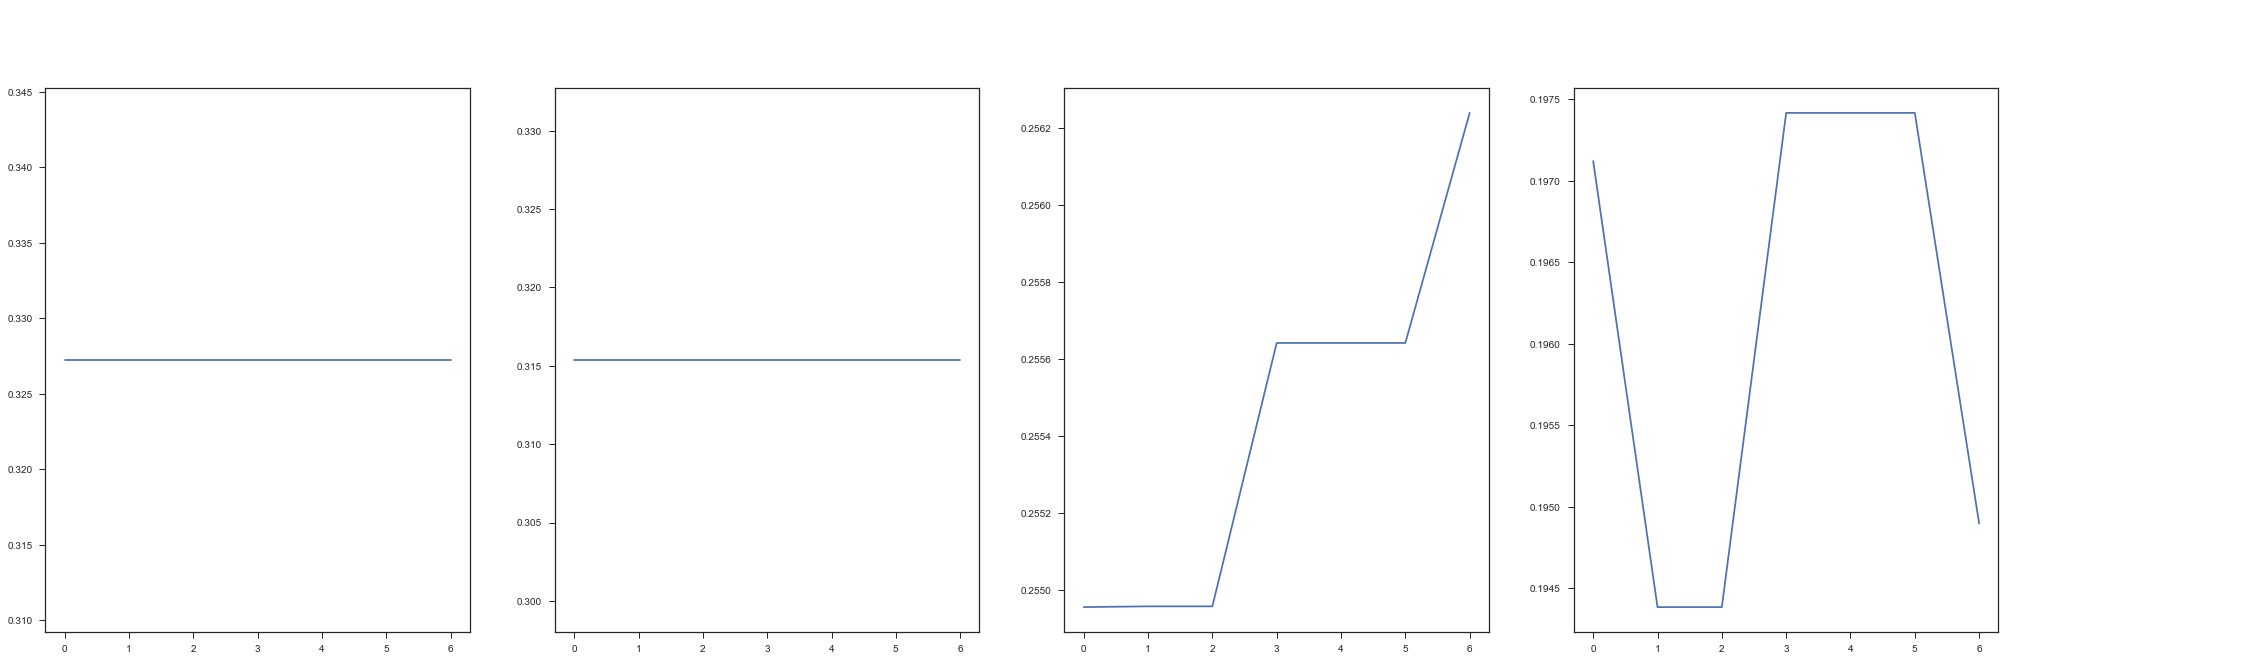

In [168]:
f, axes = plt.subplots(1, 4, figsize=(35, 10))
axes[0].plot(range(len(balancer_random_under_sampler.precision)), balancer_random_under_sampler.precision)
axes[1].plot(range(len(balancer_C_C_under_sampler.precision)), balancer_C_C_under_sampler.precision)
axes[2].plot(range(len(balancer_random_over_sampler.precision)), balancer_random_over_sampler.precision)
axes[3].plot(range(len(balancer_adasyn_over_sampler.precision)), balancer_adasyn_over_sampler.precision)
plt.show()

## Conclusion

Итак, в данной работе была:
    - проведена предварительная обработка данных посредством заполнения пропусков, нормализации признаков, исключения неинформативных признаков и т.д.;
    - построена базовая модель для логистической регрессии и медота К-ближайших соседей;
    - проверено два способа undersampling-а и oversampling-а с использованием поиска оптимальных гиперпараметров по сетке и стратифицированного перекрестного контроля;
    - графически отображена зависимость метрик от различных значений гиперпараметров.

То, что не вошло в данную работу, но, возможно, улучшило бы качество классификации:
    - включение referal source в выборку с последующей его бинаризацией;
    - использование других способов заполнения пропусков;
    - использование других стратегий undersampling-а;
    - использование данных о больных, у которых не был указан пол.

Стоит отметить, что:
    - использование undersampling-a существенно повысило качество классификации;
    - дальнейший поиск оптимальной комбинации гиперпараметров также помог, но в меньшей степени;
    - для оптимизации полноты по методу К-ближайших соседей оптимальной метрикой (при разных значениях прочих гиперпараметров) оказывается метрика Манхэттена;
    - евклидова метрика при второй стратегии undersampling-а и стратегии взвешивания 'distance' позволяет делать более точные прогнозы.

В целом, по имеющимся оценкам можно прийти к выводу, что метод К-ближайших соседей работает лучше, поскольку превосходит логистическую регрессию как в точности, так и в полноте.